In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row, col):
    cs = row[col].count("C")
    gs = row[col].count("G")
    gc = (cs+gs)/len(row[col])
    return gc

In [6]:
def calculate_cpg(row, col):
    cpgs = row[col].count("CG")
    cpg = cpgs/len(row[col])
    return cpg

In [7]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

## variables

In [8]:
motif_dir = "../../../data/04__mapped_motifs/elem_fimo_out"
motifs_f = "%s/fimo.txt.gz" % motif_dir

In [9]:
elem_map_f = "../../../data/04__mapped_motifs/fastas/elem_map.txt"

In [10]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [11]:
sig_motifs_f = "../../../data/04__mapped_motifs/sig_motifs.txt"

In [12]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED.txt"

In [13]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [14]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

In [15]:
# update to new results
expr_dir = "../../../data/03__rna_seq/04__TF_expr"
orth_expr_f = "%s/orth_TF_expression.txt" % expr_dir
human_expr_f = "%s/hESC_TF_expression.txt" % expr_dir
mouse_expr_f = "%s/mESC_TF_expression.txt" % expr_dir

In [16]:
# update to new results
orth_f = "../../../misc/00__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"

## 1. import data

In [17]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [18]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.1,0.43,0.027777800000000002,0.0175,367.0,2286.0,human,False
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.29,0.43,0.0311111,0.0175,367.0,2286.0,human,False
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011253,+,2.54,0.85,0.07111110000000001,0.0,6966.0,1361.0,human,False
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,150229045,-,0.3,0.14,0.10444400000000001,0.0,960.0,123.0,human,False
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,133799678,+,0.19,0.25,0.03,0.0,753.0,770.0,human,False


In [19]:
motifs = pd.read_table(motifs_f, sep="\t")
motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,elem_7205,1,30,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
1,ZNF212,elem_7205,3,32,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
2,ZNF212,elem_10288,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
3,ZNF212,elem_7205,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
4,ZNF212,elem_10288,7,36,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA


In [20]:
elem_map = pd.read_table(elem_map_f, sep="\t")
elem_map.head()

,elem_key,elem
0,elem_1,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...
1,elem_2,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...
2,elem_3,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...
3,elem_4,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...
4,elem_5,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...


In [21]:
motif_map = pd.read_table(motif_map_f, sep="\t")
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [22]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [23]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

487


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,6.281798,0.012198,0.000384,0.048118,0.037451,HKR1,HKR1,activating,NaN,NaN,NaN,3.0
1,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004341,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
2,M00224_1,8.999747,0.002700,0.000550,-0.228712,0.010206,M00224_1,TWIST2,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027823,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M00242_1,18.650533,0.000016,0.001140,-0.321524,0.000096,M00242_1,SCX,repressing,NaN,1.0,NaN,NaN


In [24]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


## 2. filter to significant motifs only (found via model)

In [26]:
mapped_sig_motifs = motifs[motifs["#pattern name"].isin(sig_motifs["index"])]
len(mapped_sig_motifs)

853831

In [27]:
uniq_motifs = list(mapped_sig_motifs["#pattern name"].unique())
print(len(uniq_motifs))

464


## 3. join motifs w/ elem metadata

In [28]:
motifs_merged = mapped_sig_motifs.merge(elem_map, left_on="sequence name", right_on="elem_key")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,elem_key,elem
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...


In [29]:
motifs_merged = motifs_merged.merge(index_elem, left_on="elem", right_on="element")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,element,tile_type,element_id,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0


In [30]:
motifs_merged["tss_id"] = motifs_merged["name"].str.split("__", expand=True)[1]
motifs_merged["species"] = motifs_merged["name"].str.split("_", expand=True)[0]
motifs_merged["tss_tile_num"] = motifs_merged["name"].str.split("__", expand=True)[2]
motifs_merged.sample(5)

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info,tss_id,species,tss_tile_num
744066,M10335_1,elem_4192,2,19,-,13.90820,0.000006,0.0221,TTGGGATGGAGGAGGTGG,elem_4192,...,MOUSE_EVO_TSS__m.2859__tile2,1.0,chr7,-,63217903,63218047,13172.1.0.0,m.2859,MOUSE,tile2
616569,M09391_1,elem_4369,104,116,-,9.33945,0.000076,0.0323,CAAGCCCCCCACC,elem_4369,...,MOUSE_EVO_TSS__m.2426__tile2,1.0,chr2,-,17977693,17977837,10700.1.0.0,m.2426,MOUSE,tile2
337312,M10432_1,elem_6226,100,107,-,15.00000,0.000007,0.0141,GGGCGGGG,elem_6226,...,MOUSE_EVO_TSS__m.914__tile1,1.0,chr9,-,100446497,100446641,14026.1.0.0,m.914,MOUSE,tile1
266821,M05963_1,elem_7235,75,86,+,11.88780,0.000014,0.0473,TGCTCATGCGCC,elem_7235,...,MOUSE_EVO_TSS__m.847__tile1,1.0,chr11,-,100406868,100407012,8560.1.0.0,m.847,MOUSE,tile1
244704,M03040_1,elem_1905,23,37,-,12.92860,0.000022,0.1510,ATGATTGGTCGGCTC,elem_1905,...,MOUSE_EVO_TSS__m.2095__tile1,1.0,chr17,+,3102462,3102606,9940.1.0.0,m.2095,MOUSE,tile1


In [31]:
human_df = motifs_merged[(motifs_merged["species"] == "HUMAN") | (motifs_merged["name"] == "random_sequence")]
mouse_df = motifs_merged[(motifs_merged["species"] == "MOUSE") | (motifs_merged["name"] == "random_sequence")]

human_df = human_df.merge(tss_map[["hg19_id", "biotype_hg19", 
                                   "minimal_biotype_hg19", "stem_exp_hg19", "orig_species"]], 
                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "biotype_mm9", 
                                   "minimal_biotype_mm9", "stem_exp_mm9", "orig_species"]], 
                          left_on="tss_id", right_on="mm9_id", how="left")

print(len(human_df))
print(len(mouse_df))
mouse_df.sample(5)

464572
460582


,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,actual_end,dupe_info,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,orig_species
457339,M08749_1,elem_9677,119,128,+,12.20410,0.000031,0.4020,TCCAGGTGTC,elem_9677,...,0,none,None,random,None,NaN,NaN,NaN,NaN,NaN
280117,M10051_1,elem_4823,34,52,+,9.60000,0.000075,0.1360,GCGTCCCTCTCCCTCCCCT,elem_4823,...,107832872,12332.1.0.0,m.2642,MOUSE,tile2,m.2642,divergent,other,0.05125,mouse
158728,ZNF880,elem_9314,32,58,-,9.52727,0.000054,0.0117,CTGTCCGCCTCCTTCTTCCCCCGCCTG,elem_9314,...,73224579,13622.1.0.0,m.2390,MOUSE,tile2,m.2390,antisense,other,0.11375,mouse
48281,ZNF202,elem_8386,66,73,-,6.10204,0.000066,0.0725,CCGCATCC,elem_8386,...,25918457,13030.1.0.0,m.3483,MOUSE,tile2,m.3483,enhancer,NaN,0.153347,human
103185,M06854_1,elem_6396,55,66,+,12.07140,0.000030,0.0383,GAGGGAGGGGGA,elem_6396,...,49928792,13577.1.0.0,m.183,MOUSE,tile2,m.183,divergent,other,0.0,human


In [32]:
human_df = human_df.drop_duplicates()
mouse_df = mouse_df.drop_duplicates()

print(len(human_df))
print(len(mouse_df))

457658
429119


## 4. merge cis/trans interaction data w/ elem data for model

In [33]:
index_elem = index_elem[index_elem["name"].str.contains("EVO")]
index_elem.head()

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
58627,CTTCGTGCCTGGACACCGTCCCCCAGCCTGGCTCCAGCTGCCCCGG...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile2:1355317-1355461,+...",HUMAN_EVO_TSS__h.1539__tile2,1.0,chr1,+,1355317,1355461,11.1.0.0
58640,CTGGGAGCGGCCTAGGGCGGCCGCCAGACCCAGCGCTGTGGCCCCC...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile1:1355431-1355575,+...",HUMAN_EVO_TSS__h.1539__tile1,1.0,chr1,+,1355431,1355575,12.1.0.0
58653,GGGCTGACGCTGCCTTGGGTTCGCCTACGTCCCTCGGGAATTTTGT...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile2:1447313-1447457,+...",HUMAN_EVO_TSS__h.3020__tile2,1.0,chr1,+,1447313,1447457,13.1.0.0
58666,CCACACACACCCCTTCCTCCCGGCGATAGAAGCGCGTAAGGGACAC...,WILDTYPE,"HUMAN_EVO_TSS__h.2871__tile1:1447388-1447532,-...",HUMAN_EVO_TSS__h.2871__tile1,1.0,chr1,-,1447388,1447532,14.1.0.0
58679,AGTCGCGGCGCCGTCGCTATGGCGTCACTGTCCTCGGGGCCAATCC...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile1:1447427-1447571,+...",HUMAN_EVO_TSS__h.3020__tile1,1.0,chr1,+,1447427,1447571,15.1.0.0


In [34]:
index_elem["tss_id"] = index_elem["name"].str.split("__", expand=True)[1]
index_elem["tss_tile_num"] = index_elem["name"].str.split("__", expand=True)[2]
index_elem.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
202485,CGTTTGGCGCCCGGTGTGTGGCCTTGCATATCCTTGCAGTGAAAAG...,WILDTYPE,MOUSE_EVO_TSS__m.1969__tile2:11315038-11315182...,MOUSE_EVO_TSS__m.1969__tile2,1.0,chr4,+,11315038,11315182,11691.1.0.0,m.1969,tile2
75319,GGAGGCGGACCCTGCACGCCCGGCGGCTCCGCGCCCCGTGATTGGT...,WILDTYPE,HUMAN_EVO_TSS__h.1627__tile2:71159488-71159632...,HUMAN_EVO_TSS__h.1627__tile2,1.0,chr11,+,71159488,71159632,1346.1.0.0,h.1627,tile2
169972,TAGCAGCATTAATTTCGTTGATTGTGAATATGCAAGCTGTTCCTGC...,WILDTYPE,MOUSE_EVO_TSS__m.2276__tile2:20446472-20446616...,MOUSE_EVO_TSS__m.2276__tile2,1.0,chr13,+,20446472,20446616,9030.1.0.0,m.2276,tile2
187717,GGGGGGGGACACCTCACTTCCGCTTGGTGGTCCGGGACTAGATCTC...,WILDTYPE,"MOUSE_EVO_TSS__m.2795__tile2:7457013-7457157,-...",MOUSE_EVO_TSS__m.2795__tile2,1.0,chr19,-,7457013,7457157,10496.1.0.0,m.2795,tile2
172481,TGGACGAAAGGAAAGAAACAGCCGCGGACCGGCCCCCGGCTGCGCA...,WILDTYPE,"MOUSE_EVO_TSS__m.949__tile1:99086904-99087048,...",MOUSE_EVO_TSS__m.949__tile1,1.0,chr13,-,99086904,99087048,9238.1.0.0,m.949,tile1


In [35]:
index_human = index_elem[index_elem["name"].str.contains("HUMAN")]
index_mouse = index_elem[index_elem["name"].str.contains("MOUSE")]
index_mouse.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
198676,TCAGATTTTGTTCATGAGAACCCAGGAAACAAAAATTAAGATTGTT...,WILDTYPE,MOUSE_EVO_TSS__m.3277__tile1:85834106-85834250...,MOUSE_EVO_TSS__m.3277__tile1,1.0,chr3,-,85834106,85834250,11381.1.0.0,m.3277,tile1
232216,TCCATTTATTTTCTTGATATCAGGAAGAATAAGAGTTAAAGAGGGT...,WILDTYPE,MOUSE_EVO_TSS__m.1797__tile1:18739194-18739338...,MOUSE_EVO_TSS__m.1797__tile1,1.0,chrX,-,18739194,18739338,14155.1.0.0,m.1797,tile1
150329,GCATCTCAGAAGAGAAAGGAAGCCACTGCTAATGGCCTGTGACAGC...,WILDTYPE,MOUSE_EVO_TSS__m.2247__tile1:72333486-72333630...,MOUSE_EVO_TSS__m.2247__tile1,1.0,chr1,-,72333486,72333630,7430.1.0.0,m.2247,tile1
159611,AAATTACATTTTTTTTTTTGAACGATGAGGGAACATCTAATCAAAG...,WILDTYPE,MOUSE_EVO_TSS__m.1940__tile1:21903232-21903376...,MOUSE_EVO_TSS__m.1940__tile1,1.0,chr11,+,21903232,21903376,8182.1.0.0,m.1940,tile1
195881,GAATGAGGTGGCTCTGCCCGTGCAGCGCTCTATGGCTGATGTTTCC...,WILDTYPE,MOUSE_EVO_TSS__m.2935__tile2:162948122-1629482...,MOUSE_EVO_TSS__m.2935__tile2,1.0,chr2,+,162948122,162948266,11159.1.0.0,m.2935,tile2


In [36]:
print(len(data))
data_elem = data.merge(index_human[["element", "tss_id", "tss_tile_num"]], left_on=["hg19_id", "tss_tile_num"],
                       right_on=["tss_id", "tss_tile_num"])
data_elem = data_elem.merge(index_mouse[["element", "tss_id", "tss_tile_num"]], left_on=["mm9_id", "tss_tile_num"],
                            right_on=["tss_id", "tss_tile_num"], suffixes=("_human", "_mouse"))
data_elem.drop(["tss_id_human", "tss_id_mouse"], axis=1, inplace=True)
print(len(data))
data_elem.head()

5482
5482


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...


In [37]:
data_elem["gc_human"] = data_elem.apply(calculate_gc, col="element_human", axis=1)
data_elem["gc_mouse"] = data_elem.apply(calculate_gc, col="element_mouse", axis=1)
data_elem["cpg_human"] = data_elem.apply(calculate_cpg, col="element_human", axis=1)
data_elem["cpg_mouse"] = data_elem.apply(calculate_cpg, col="element_mouse", axis=1)
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse,gc_human,gc_mouse,cpg_human,cpg_mouse
2363,h.3202,chr17,47964718.0,no cage activity,no cage activity,no cage activity,no CAGE activity,no cage activity,m.3013,chr11,...,-0.088364,0.987564,no cis/trans int. effect,no cis/trans int. effect,CATCCCCTGTGGAATGGTGGAATGCAGGGAACCTCCTGTTCCTGCT...,GTGGAATGCCAGGAACCTCCTATTCCTGCCGACACCCTCTCCTCAA...,0.604167,0.659722,0.006944,0.020833
2745,h.55,chr11,65266461.0,intergenic,"chr11:65266459..65266465,-",ENSG00000270117.1,lncRNA,0.043333300000000005,m.36,chr19,...,-0.585453,0.429063,no cis/trans int. effect,no cis/trans int. effect,TTAAAATTACGTTAAAAACTTAACGCTAAGCAATATCTTAGTAACC...,TATCTGCGATTTCCTCGGGCTGAGTCTCCTGCCTCACGAGCTCAGC...,0.333333,0.597222,0.027778,0.076389
4910,h.2864,chr2,85766863.0,no cage activity,no cage activity,no cage activity,other,no cage activity,m.2675,chr6,...,-0.014697,0.995274,no cis/trans int. effect,no cis/trans int. effect,TGTGCGTATTCTCCAGTGTGTAGTCAAGACCTAACCACTGAGGCAG...,GCATGTCTACCCATGCTCTTAAGCGTTTTCCAGGGGCCGGAAGTCA...,0.625000,0.590278,0.041667,0.048611
5122,h.3148,chr12,122238322.0,no cage activity,no cage activity,no cage activity,other,no cage activity,m.2959,chr5,...,-0.462711,0.846301,no cis/trans int. effect,no cis/trans int. effect,CCGGAGATCTGAGGCTTCGCCGGGAGCCCCGCGCCTCGGGGGATCC...,GGCGGGGGGCTGGGGGGGATCCCGAAGGGGAGGCCCCAATCGGCTT...,0.763889,0.680556,0.083333,0.034722
2501,h.3376,chrX,40944251.0,no cage activity,no cage activity,no cage activity,mRNA,no cage activity,m.3186,chrX,...,0.224791,0.919649,no cis/trans int. effect,no cis/trans int. effect,ATTAACCCTGTCGTGGCCACACACCCCGCCAGTCCCTGCCGCCCAG...,CCTGTCCACATCCCTGCCATTCCCGACAGTCAGTCCCTTTGCCCAG...,0.673611,0.618056,0.062500,0.055556


In [38]:
data_elem["delta_gc"] = data_elem["gc_mouse"] - data_elem["gc_human"] 
data_elem["delta_cpg"] = data_elem["cpg_mouse"] - data_elem["cpg_human"]
data_elem["mean_gc"] = data_elem[["gc_mouse", "gc_human"]].mean(axis=1)
data_elem["mean_cpg"] = data_elem[["cpg_mouse", "cpg_human"]].mean(axis=1)
data_elem["abs_delta_gc"] = np.abs(data_elem["delta_gc"])
data_elem["abs_delta_cpg"] = np.abs(data_elem["delta_cpg"])
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,gc_human,gc_mouse,cpg_human,cpg_mouse,delta_gc,delta_cpg,mean_gc,mean_cpg,abs_delta_gc,abs_delta_cpg
1245,h.1727,chr17,80416394.0,divergent,"chr17:80416387..80416403,-",ENSG00000265458.1,lncRNA,0.773333,m.1539,chr11,...,0.701389,0.625000,0.097222,0.055556,-0.076389,-0.041667,0.663194,0.076389,0.076389,0.041667
2351,h.3186,chr9,125117386.0,no cage activity,no cage activity,no cage activity,no CAGE activity,no cage activity,m.2997,chr2,...,0.597222,0.597222,0.013889,0.000000,0.000000,-0.013889,0.597222,0.006944,0.000000,0.013889
4610,h.2526,chr2,80371690.0,enhancer,chr2:80371410-80371698,chr2:80371410-80371698__POSITIVE,eRNA,0.0706833,m.2338,chr6,...,0.256944,0.298611,0.006944,0.000000,0.041667,-0.006944,0.277778,0.003472,0.041667,0.006944
4118,h.1865,chr12,66524640.0,divergent,"chr12:66524623..66524647,+",ENSG00000239335.4,lncRNA,1.08667,m.1677,chr10,...,0.583333,0.680556,0.076389,0.125000,0.097222,0.048611,0.631944,0.100694,0.097222,0.048611
203,h.331,chr7,73149376.0,intergenic,"chr7:73149373..73149380,+",ENSG00000225969.1,lncRNA,0.0,m.214,chr5,...,0.638889,0.576389,0.006944,0.000000,-0.062500,-0.006944,0.607639,0.003472,0.062500,0.006944


In [39]:
data_elem.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 'start_tss_mm9',
       'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'tss_tile_num', 'orig_species',
       'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9',
       'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status',
       'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64',
       'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status',
       'trans_human_status_det', 'trans_mou

In [40]:
data_elem["abs_logFC_int"] = np.abs(data_elem["logFC_int"])
data_elem["box_abs_logFC_int"] = boxcox(data_elem["abs_logFC_int"])[0]

## 5. build reduced model

In [41]:
scaled_features = StandardScaler().fit_transform(data_elem[["box_abs_logFC_int", "abs_delta_gc", "abs_delta_cpg",
                                                            "mean_gc", "mean_cpg"]])
data_norm = pd.DataFrame(scaled_features, index=data_elem.index, columns=["box_abs_logFC_int", "abs_delta_gc", 
                                                                          "abs_delta_cpg", "mean_gc", "mean_cpg"])
data_norm["HUES64_padj_hg19"] = data_elem["HUES64_padj_hg19"]
data_norm["mESC_padj_mm9"] = data_elem["mESC_padj_mm9"]
data_norm["element_human"] = data_elem["element_human"]
data_norm["element_mouse"] = data_elem["element_mouse"]
data_norm["hg19_id"] = data_elem["hg19_id"]
data_norm["mm9_id"] = data_elem["mm9_id"]
data_norm["tss_tile_num"] = data_elem["tss_tile_num"]
data_norm["cis_trans_int_status"] = data_elem["cis_trans_int_status"]
data_norm.head()

,box_abs_logFC_int,abs_delta_gc,abs_delta_cpg,mean_gc,mean_cpg,HUES64_padj_hg19,mESC_padj_mm9,element_human,element_mouse,hg19_id,mm9_id,tss_tile_num,cis_trans_int_status
0,-1.477735,-1.059543,-0.711892,0.863260,0.926777,1.812116e-03,0.692688,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,h.2,m.1,tile1,no cis/trans int. effect
1,0.603227,0.392234,-0.711892,1.428900,2.688934,4.883017e-01,0.055405,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...,h.3,m.2,tile1,no cis/trans int. effect
2,-0.175079,-1.059543,-0.711892,0.439030,-0.639585,2.428031e-01,0.368915,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...,h.4,m.3,tile1,no cis/trans int. effect
3,1.460588,-0.624010,-1.068000,-1.222537,-0.345892,1.368040e-14,0.003826,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.5,m.4,tile1,no cis/trans int. effect
4,0.963389,-1.059543,-0.711892,-1.045775,-0.247994,3.003835e-10,0.003826,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.6,m.4,tile1,no cis/trans int. effect


In [42]:
data_filt = data_norm[((data_norm["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_norm["mESC_padj_mm9"] < QUANT_ALPHA))]
print(len(data_filt))
data_filt.head()

2307


,box_abs_logFC_int,abs_delta_gc,abs_delta_cpg,mean_gc,mean_cpg,HUES64_padj_hg19,mESC_padj_mm9,element_human,element_mouse,hg19_id,mm9_id,tss_tile_num,cis_trans_int_status
0,-1.477735,-1.059543,-0.711892,0.863260,0.926777,1.812116e-03,6.926885e-01,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,h.2,m.1,tile1,no cis/trans int. effect
3,1.460588,-0.624010,-1.068000,-1.222537,-0.345892,1.368040e-14,3.825929e-03,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.5,m.4,tile1,no cis/trans int. effect
4,0.963389,-1.059543,-0.711892,-1.045775,-0.247994,3.003835e-10,3.825929e-03,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.6,m.4,tile1,no cis/trans int. effect
5,-1.851517,1.263300,3.561407,0.721850,0.926777,7.028182e-155,7.231567e-115,TAAACTCACAGGCGCCATAAGGACAACCCAGGCAGGAGGCCTTCGT...,CTGAGCAGGCGTTGTGAGGACAGCCCGGCCCGGCGGCCATCGCAGC...,h.7,m.5,tile1,no cis/trans int. effect
9,0.065196,0.682589,-0.355783,0.651145,0.828880,0.000000e+00,1.485704e-153,CGCCGGCCTCACCTACGGTGCCGCAAAATGCTGGTGCCTTTACTGC...,CAGTCCCCAAACCATGTGCCCATCAGAGACAGAGCTTCCGGGTCTC...,h.11,m.8,tile1,no cis/trans int. effect


In [43]:
mod = smf.ols(formula='box_abs_logFC_int ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg', 
              data=data_filt).fit()

In [44]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      box_abs_logFC_int   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.636
Date:                Tue, 05 Nov 2019   Prob (F-statistic):           0.000163
Time:                        09:42:24   Log-Likelihood:                -3358.6
No. Observations:                2307   AIC:                             6727.
Df Residuals:                    2302   BIC:                             6756.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1772      0.025      6.982      0.000       0.127       0.227
mean_gc           0.0135      0.042      0.322      0.747      -0.069       0.096
mean_cpg         -0.0911      0.034     -2.709      0.007      -0.157      -0.025
abs_delta_gc      0.0289      0.026      1.098      0.273      -0.023       0.081
abs_delta_cpg     0.0490      0.025      1.976      0.048       0.000       0.098
==============================================================================
Omnibus:                       14.176   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               12.878
Skew:                          -0.138   Prob(JB):                      0.00160
Kurtosis:                       2.759   Cond. No.                         3.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

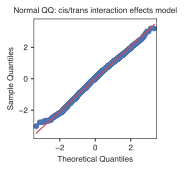

In [45]:
res = mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: cis/trans interaction effects model")
fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [46]:
reduced_llf = mod.llf
reduced_llf

-3358.5840979479472

In [47]:
reduced_rsq = mod.rsquared
reduced_rsq

0.0096990084579797742

## 6. add motifs to model

In [48]:
data_filt["hg19_index"] = data_filt["hg19_id"] + "__" + data_filt["tss_tile_num"]
data_filt["mm9_index"] = data_filt["mm9_id"] + "__" + data_filt["tss_tile_num"]

In [49]:
human_df["hg19_index"] = human_df["hg19_id"] + "__" + human_df["tss_tile_num"]
mouse_df["mm9_index"] = mouse_df["mm9_id"] + "__" + mouse_df["tss_tile_num"]

In [50]:
def motif_disrupted(row):
    if row["motif_sum"] == 1:
        return "c - disrupted"
    elif row["motif_sum"] == 0:
        return "b - not present"
    else:
        return "a - maintained"

In [51]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_df[human_df["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_df[mouse_df["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["hg19_motif"] = tmp["hg19_index"].isin(human_motifs_sub)
    tmp["mm9_motif"] = tmp["mm9_index"].isin(mouse_motifs_sub)
    
    tmp["motif_sum"] = tmp[["hg19_motif", "mm9_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    n_maintained = len(tmp[tmp["motif_disrupted"] == "a - maintained"])
    
    # make reduced model
    mod = smf.ols(formula='box_abs_logFC_int ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg', 
                  data=tmp).fit()
    reduced_llf = mod.llf
    reduced_rsq = mod.rsquared
    
    # make full model
    full_mod = smf.ols(formula='box_abs_logFC_int ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg + motif_disrupted', 
                       data=tmp).fit()
    full_llf = full_mod.llf
    full_rsq = full_mod.rsquared
    
    # perform likelihood ratio test
    lr, p = lrtest(reduced_llf, full_llf)
    
    # calculate additional variance explained
    rsq = full_rsq - reduced_rsq
    
    # record beta
    beta = list(full_mod.params)[2]
    
    # beta p
    beta_p = list(full_mod.pvalues)[2]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(tmp), p, rsq))
    motif_results[motif_id] = {"lr_test": lr, "pval": p, "rsq": rsq, "beta": beta, "beta_p": beta_p,
                               "n_maintained": n_maintained}

(#1) ZNF785: n w/ motif: 2307 ... p: 0.366170199922, rsquared: 0.000350479700952
(#2) ZNF235: n w/ motif: 2307 ... p: 0.00336311645286, rsquared: 0.00368441261531
(#3) ZNF432: n w/ motif: 2307 ... p: 0.000832101490851, rsquared: 0.00478247851684
(#4) ZNF93: n w/ motif: 2307 ... p: 0.318347368857, rsquared: 0.000427331508234
(#5) ZNF487: n w/ motif: 2307 ... p: 0.0839789536528, rsquared: 0.00128100859954
(#6) M10350_1: n w/ motif: 2307 ... p: 0.202862759901, rsquared: 0.00069586085979
(#7) ZNF304: n w/ motif: 2307 ... p: 0.0598373018876, rsquared: 0.0015192216699
(#8) ZNF880: n w/ motif: 2307 ... p: 0.358198291125, rsquared: 0.000362314378991
(#9) M08865_1: n w/ motif: 2307 ... p: 0.298159211817, rsquared: 0.000464525160128
(#10) ZNF180: n w/ motif: 2307 ... p: 0.0216344289399, rsquared: 0.00226173346726
(#11) ZNF311: n w/ motif: 2307 ... p: 0.0235041085384, rsquared: 0.00220002059156
(#12) ZNF780A: n w/ motif: 2307 ... p: 0.0721101747365, rsquared: 0.00138738945267
(#13) M08863_1: n w/

(#101) M08876_1: n w/ motif: 2307 ... p: 0.0182699592722, rsquared: 0.00238812262739
(#102) M08874_1: n w/ motif: 2307 ... p: 0.0750772379012, rsquared: 0.001359119444
(#103) ZNF417: n w/ motif: 2307 ... p: 0.00117288100433, rsquared: 0.0045109036335
(#104) M05568_1: n w/ motif: 2307 ... p: 0.000907300788445, rsquared: 0.00471393725897
(#105) M06672_1: n w/ motif: 2307 ... p: 0.00164461488063, rsquared: 0.00424446018266
(#106) M08827_1: n w/ motif: 2307 ... p: 0.142824030131, rsquared: 0.000921304833829
(#107) ZNF528: n w/ motif: 2307 ... p: 0.0443156960518, rsquared: 0.00173461477907
(#108) M10405_1: n w/ motif: 2307 ... p: 0.103898489068, rsquared: 0.00113459351132
(#109) M06854_1: n w/ motif: 2307 ... p: 0.194939672235, rsquared: 0.000720843823365
(#110) M09349_1: n w/ motif: 2307 ... p: 0.552774593308, rsquared: 0.000151246511125
(#111) M06186_1: n w/ motif: 2307 ... p: 0.56442445904, rsquared: 0.000142547221433
(#112) M06131_1: n w/ motif: 2307 ... p: 0.00821240713107, rsquared: 0

(#199) M10316_1: n w/ motif: 2307 ... p: 0.785179026163, rsquared: 3.18924894475e-05
(#200) M10001_1: n w/ motif: 2307 ... p: 0.134859031196, rsquared: 0.000959212778099
(#201) M03012_1: n w/ motif: 2307 ... p: 0.0209835402127, rsquared: 0.00228452211739
(#202) M08731_1: n w/ motif: 2307 ... p: 0.165461370049, rsquared: 0.000825374845052
(#203) M05766_1: n w/ motif: 2307 ... p: 0.450791223939, rsquared: 0.000244073174954
(#204) ZNF587: n w/ motif: 2307 ... p: 0.136899095244, rsquared: 0.000949268979901
(#205) M06241_1: n w/ motif: 2307 ... p: 0.482112551559, rsquared: 0.000212066049039
(#206) M10440_1: n w/ motif: 2307 ... p: 0.116046856792, rsquared: 0.00105965097478
(#207) M05982_1: n w/ motif: 2307 ... p: 0.273851064326, rsquared: 0.000513842100558
(#208) M09267_1: n w/ motif: 2307 ... p: 0.494811965094, rsquared: 0.000200034214658
(#209) M09265_1: n w/ motif: 2307 ... p: 0.347249263637, rsquared: 0.000379170952947
(#210) M09241_1: n w/ motif: 2307 ... p: 0.491542814325, rsquared: 0

(#297) M09828_1: n w/ motif: 2307 ... p: 0.0948021714132, rsquared: 0.00119728645614
(#298) M06027_1: n w/ motif: 2307 ... p: 0.106341946021, rsquared: 0.00111877211122
(#299) M09333_1: n w/ motif: 2307 ... p: 0.179710178119, rsquared: 0.000772373441067
(#300) M09011_1: n w/ motif: 2307 ... p: 0.249204061431, rsquared: 0.000569789333122
(#301) M09445_1: n w/ motif: 2307 ... p: 0.000124410078094, rsquared: 0.00630055672694
(#302) M09363_1: n w/ motif: 2307 ... p: 0.299172265664, rsquared: 0.000462581905746
(#303) M06175_1: n w/ motif: 2307 ... p: 0.00995717751058, rsquared: 0.00284727114708
(#304) M00255_1: n w/ motif: 2307 ... p: 0.541111981391, rsquared: 0.000160307919239
(#305) M09341_1: n w/ motif: 2307 ... p: 0.143063155729, rsquared: 0.00092020370355
(#306) M08769_1: n w/ motif: 2307 ... p: 0.206896315609, rsquared: 0.000683579075927
(#307) M08470_1: n w/ motif: 2307 ... p: 0.163152019309, rsquared: 0.00083445679854
(#308) M08469_1: n w/ motif: 2307 ... p: 0.198134153318, rsquared

(#395) M10360_1: n w/ motif: 2307 ... p: 0.215597348416, rsquared: 0.000658023225103
(#396) M09039_1: n w/ motif: 2307 ... p: 0.00558810498153, rsquared: 0.003290609088
(#397) M09990_1: n w/ motif: 2307 ... p: 0.0463752408064, rsquared: 0.00170179889359
(#398) M09119_1: n w/ motif: 2307 ... p: 0.916963651135, rsquared: 4.66602878946e-06
(#399) M08749_1: n w/ motif: 2307 ... p: 0.0441125504816, rsquared: 0.00173793821255
(#400) M10356_1: n w/ motif: 2307 ... p: 0.00500765465385, rsquared: 0.00337536858086
(#401) M09817_1: n w/ motif: 2307 ... p: 0.00556034488269, rsquared: 0.00329445413928
(#402) M09415_1: n w/ motif: 2307 ... p: 0.394966739364, rsquared: 0.000310561727763
(#403) M08947_1: n w/ motif: 2307 ... p: 0.0793425034841, rsquared: 0.0013205154655
(#404) ZNF343: n w/ motif: 2307 ... p: 0.00736723108258, rsquared: 0.00307779414695
(#405) ZNF641: n w/ motif: 2307 ... p: 0.117023752862, rsquared: 0.00105400358212
(#406) M10345_1: n w/ motif: 2307 ... p: 0.003217141421, rsquared: 0.

In [52]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results = motif_results[motif_results["n_maintained"] >= 10]
print(len(motif_results))
motif_results.head()

366


,index,lr_test,pval,rsq,beta,beta_p,n_maintained
0,HKR1,0.067005,0.795748,0.000029,0.015132,0.797795,561
3,M00226_1,3.578368,0.058537,0.001535,0.048599,0.831655,27
5,M00255_1,0.373483,0.541112,0.000160,0.059381,0.715871,59
7,M00267_1,2.104763,0.146841,0.000903,-0.080996,0.691306,35
8,M00402_1,1.778394,0.182347,0.000763,0.147776,0.449372,38


In [53]:
motif_results["padj"] = multicomp.multipletests(motif_results["pval"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

18

In [56]:
motif_results["beta_padj"] = multicomp.multipletests(motif_results["beta_p"], method="fdr_bh")[1]
len(motif_results[motif_results["beta_padj"] < 0.1])

22

In [57]:
motif_results.sort_values(by="beta_padj").head(10)

,index,lr_test,pval,rsq,beta,beta_p,n_maintained,padj,beta_padj
34,M03040_1,11.892781,0.000564,0.005092,0.335288,0.000827,205,0.030602,0.079142
212,M08663_1,11.530982,0.000684,0.004937,0.577779,0.000872,55,0.030602,0.079142
426,ZNF432,11.168226,0.000832,0.004782,0.194101,0.001153,523,0.030602,0.079142
312,M09385_1,10.696864,0.001073,0.004581,0.538781,0.002231,39,0.030602,0.079142
319,M09436_1,9.648710,0.001895,0.004133,0.498105,0.002208,65,0.038529,0.079142
190,M08485_1,10.673272,0.001087,0.004571,0.526821,0.002090,64,0.030602,0.079142
160,M06674_1,11.120401,0.000854,0.004762,0.298724,0.001642,209,0.030602,0.079142
47,M05568_1,11.007783,0.000907,0.004714,0.565836,0.001533,56,0.030602,0.079142
28,M02098_1,9.655247,0.001888,0.004136,0.483716,0.002379,63,0.038529,0.079142
155,M06474_1,12.030460,0.000523,0.005151,0.346129,0.000732,190,0.030602,0.079142


## 7. join w/ TF info

In [58]:
motif_results_mrg = motif_results.merge(sig_motifs, on="index", suffixes=("_int", "_activ"))
motif_results_mrg.sort_values(by="padj_int").head()

,index,lr_test_int,pval_int,rsq_int,beta_int,beta_p,n_maintained,padj_int,beta_padj,lr_test_activ,...,rsq_activ,beta_activ,padj_activ,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
195,M08957_1,45.320678,1.672737e-11,0.019264,-0.449555,0.044577,31,6.122216e-09,0.297565,25.832229,...,0.001579,0.278681,2.938202e-06,M08957_1,NFE2,activating,NaN,1.0,NaN,NaN
73,M05934_1,24.708161,6.670112e-07,0.010550,0.025554,0.909000,33,1.220631e-04,0.972726,9.212466,...,0.000563,0.160023,9.240390e-03,M05934_1,NFE2,activating,NaN,1.0,NaN,NaN
137,M06885_1,22.416464,2.194845e-06,0.009576,-0.041065,0.827321,44,2.677711e-04,0.937460,32.119897,...,0.001962,0.245771,1.244878e-07,M06885_1,BACH1,activating,0.0,1.0,NaN,NaN
250,M09445_1,14.724635,1.244101e-04,0.006301,0.121731,0.608913,27,1.138352e-02,0.846278,20.637242,...,0.001261,0.255024,3.603894e-05,M09445_1,BACH2,activating,NaN,1.0,NaN,NaN
121,M06674_1,11.120401,8.538331e-04,0.004762,0.298724,0.001642,209,3.060174e-02,0.079142,424.500107,...,0.025572,0.597962,9.135942e-93,M06674_1,NFYC,activating,NaN,NaN,2.0,NaN


In [60]:
#sig_results = motif_results_mrg[(motif_results_mrg["padj_cis"] < 0.05) & (motif_results_mrg["beta_cis"] > 0)]
sig_results = motif_results_mrg[(motif_results_mrg["beta_padj"] < 0.1) & (motif_results_mrg["beta_int"] > 0)]
sig_results = sig_results.sort_values(by="beta_int", ascending=False)

In [61]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [62]:
full_pal = {}
for i, row in sig_results.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

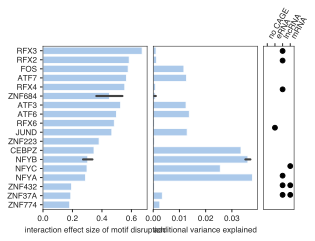

In [63]:
fig = plt.figure(figsize=(4.5, 3))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sig_results.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sig_results["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_int", data=sig_results, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("interaction effect size of motif disruption")

sns.barplot(y="HGNC symbol", x="rsq_activ", data=sig_results, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("additional variance explained")

melt = pd.melt(sig_results, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("cistrans_int_motif_enrichment.pdf", dpi="figure", bbox_inches="tight")
plt.close()